In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 98% 719M/736M [00:04<00:00, 160MB/s]
100% 736M/736M [00:04<00:00, 160MB/s]


In [5]:
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

## Import the library

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

## Load the dataset

In [7]:
glaucoma = Path('/content/dataset/glaucoma')
cataract = Path('/content/dataset/cataract')
normal = Path('/content/dataset/normal')
diabetic_retinopathy = Path('/content/dataset/diabetic_retinopathy')

In [8]:
from tqdm import tqdm

disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()

for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:05<00:00, 214.35it/s]


In [9]:
df.head()

,image,disease_type
0,/content/dataset/glaucoma/Glaucoma_054.png,0
1,/content/dataset/glaucoma/_92_2709771.jpg,0
2,/content/dataset/glaucoma/Glaucoma_013.png,0
3,/content/dataset/glaucoma/Glaucoma_076.png,0
4,/content/dataset/glaucoma/Glaucoma_010.png,0


In [10]:
df.disease_type.value_counts()

3    1098
2    1074
1    1038
0    1007
Name: disease_type, dtype: int64

In [11]:
df.shape

(4217, 2)

In [12]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [13]:
df.head()

,image,disease_type
0,/content/dataset/glaucoma/Glaucoma_054.png,glaucoma
1,/content/dataset/glaucoma/_92_2709771.jpg,glaucoma
2,/content/dataset/glaucoma/Glaucoma_013.png,glaucoma
3,/content/dataset/glaucoma/Glaucoma_076.png,glaucoma
4,/content/dataset/glaucoma/Glaucoma_010.png,glaucoma


## Visualizing Images in the dataset

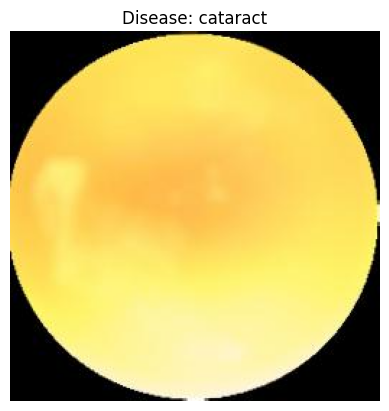

In [14]:
from PIL import Image
import random

rand_index = random.randint(0, len(df['image']) - 1)
disease_type = df['disease_type'][rand_index]
IMG = Image.open(df['image'][rand_index])
plt.title(f'Disease: {disease_type}')
plt.axis('off')
plt.imshow(IMG)
plt.show()

In [15]:
df1 = df.sample(frac=1).reset_index(drop=True)

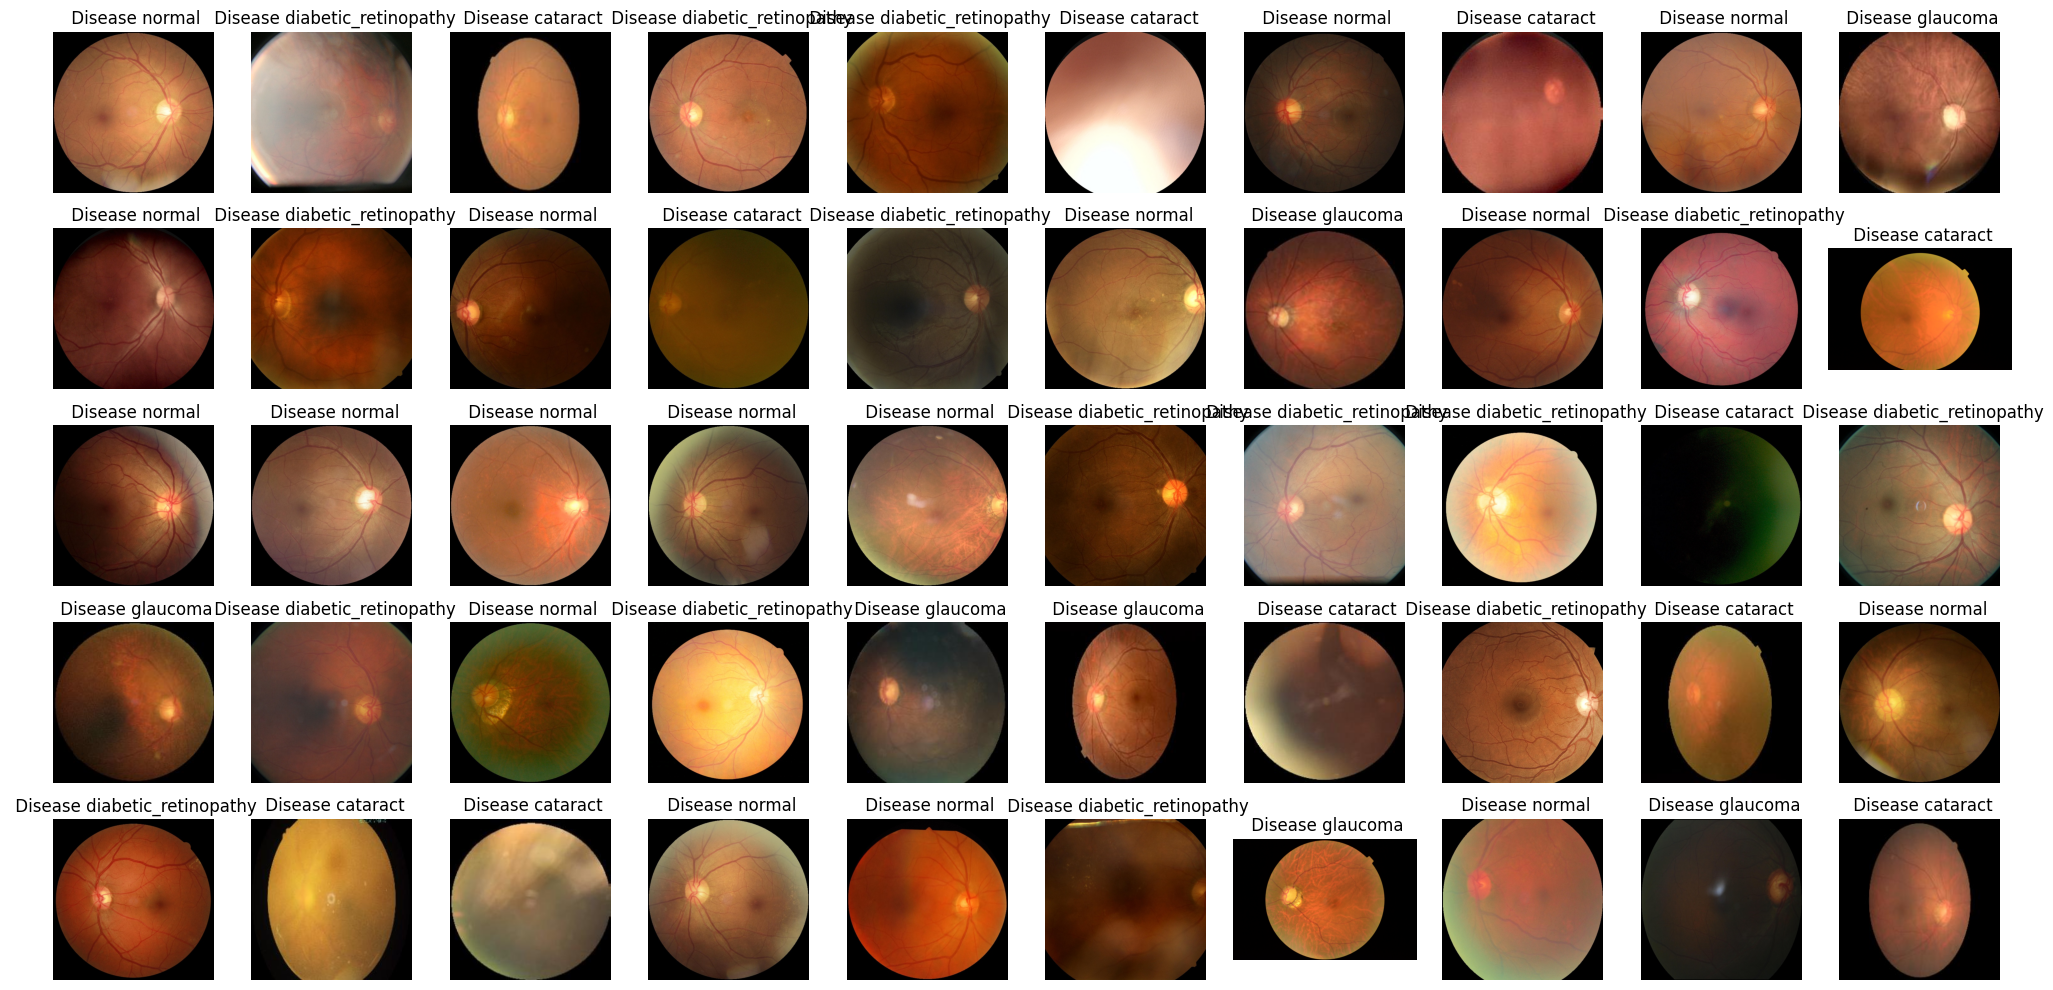

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range (50):
    plt.subplot(5,10,i+1)
    img = Image.open(df1['image'][i])
    plt.title(f' Disease {df1.disease_type[i]}')
    plt.imshow(img);
    plt.axis('off')
plt.tight_layout()
plt.show()

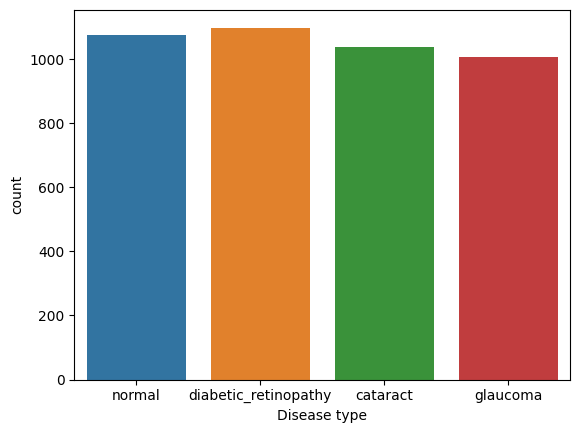

In [17]:
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

## Model training

In [18]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
data_dir='dataset'

In [20]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=(128,128),
    batch_size=32,
    label_mode='categorical'  # Use categorical labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(128,128),
    batch_size=32,
    label_mode='categorical'
)

Found 4217 files belonging to 4 classes.
Using 3163 files for training.
Found 4217 files belonging to 4 classes.
Using 1054 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [23]:
num_classes = 4

In [24]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9

In [27]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
99/99 [==============================] - 107s 1s/step - loss: 0.9942 - accuracy: 0.5545 - val_loss: 0.7568 - val_accuracy: 0.6660
Epoch 2/20
99/99 [==============================] - 95s 933ms/step - loss: 0.6185 - accuracy: 0.7373 - val_loss: 0.5791 - val_accuracy: 0.7562
Epoch 3/20
99/99 [==============================] - 103s 1s/step - loss: 0.5116 - accuracy: 0.7970 - val_loss: 0.4690 - val_accuracy: 0.8207
Epoch 4/20
99/99 [==============================] - 102s 1s/step - loss: 0.4624 - accuracy: 0.8109 - val_loss: 0.5321 - val_accuracy: 0.7789
Epoch 5/20
99/99 [==============================] - 98s 971ms/step - loss: 0.4295 - accuracy: 0.8353 - val_loss: 0.4621 - val_accuracy: 0.8235
Epoch 6/20
99/99 [==============================] - 91s 894ms/step - loss: 0.4019 - accuracy: 0.8403 - val_loss: 0.4276 - val_accuracy: 0.8311
Epoch 7/20
99/99 [==============================] - 98s 979ms/step - loss: 0.3683 - accuracy: 0.8584 - val_loss: 0.4702 - val_accuracy: 0.7951
Epoch

## Model Performance

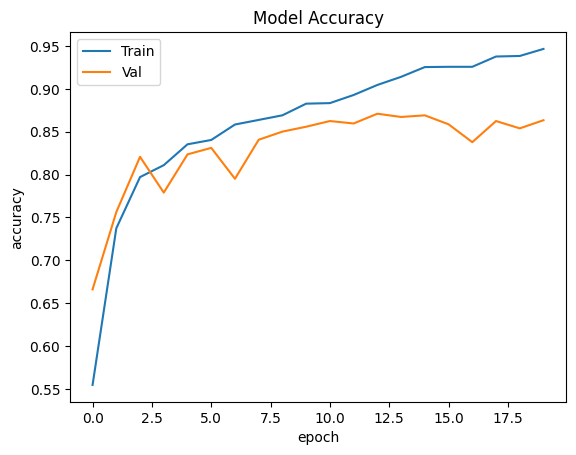

In [28]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

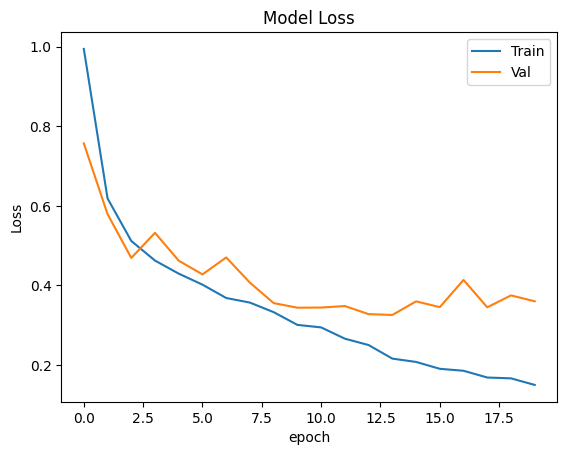

In [29]:
# create a plot of loss and val_loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [31]:
# Get the class names
class_names = train_ds.class_names

# Initialize variables to store class-wise counts
class_counts = {class_name: 0 for class_name in class_names}
class_correct_counts = {class_name: 0 for class_name in class_names}

# Iterate over the validation dataset to calculate class-level accuracy
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    true_classes = tf.argmax(labels, axis=1)

    for i in range(len(class_names)):
        class_name = class_names[i]
        class_counts[class_name] += tf.reduce_sum(tf.cast(true_classes == i, tf.int32))
        class_correct_counts[class_name] += tf.reduce_sum(tf.cast(tf.logical_and(true_classes == i, true_classes == predicted_classes), tf.int32))

# Calculate and print class-level accuracy
print('Class-level accuracy:')
for class_name in class_names:
    accuracy = class_correct_counts[class_name] / class_counts[class_name]
    print(f'{class_name}: {accuracy.numpy():.4f}')

1/1 [==============================] - 0s 403ms/step
Class-level accuracy:
cataract: 0.9350
diabetic_retinopathy: 0.9929
glaucoma: 0.7227
normal: 0.7970


## Save the Model

In [32]:
#finally save the model

tf.keras.models.save_model(model,'EyeModel.h5')

## Test the model

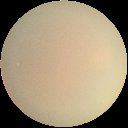

In [33]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/dataset/cataract/1062_right.jpg',target_size =(128,128))
img

In [35]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(model.predict(x))
op = {0:'cataract',1:'diabetic_retinopathy',2:'glaucoma',3:'normal'}
op[pred]

1/1 [==============================] - 0s 53ms/step


'cataract'

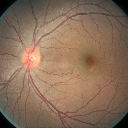

In [36]:
img = image.load_img('/content/dataset/diabetic_retinopathy/10009_right.jpeg',target_size =(128,128))
img

In [37]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(model.predict(x))
op = {0:'cataract',1:'diabetic_retinopathy',2:'glaucoma',3:'normal'}
op[pred]

1/1 [==============================] - 0s 44ms/step


'diabetic_retinopathy'